In [27]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekWHPotatoes.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [29]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,265.86830,0
2016-03-21,531.15188,29
2016-03-28,624.64136,0
2016-04-04,669.08098,0
2016-04-11,693.95366,0


In [30]:
print(df.index.freq)

<Week: weekday=0>


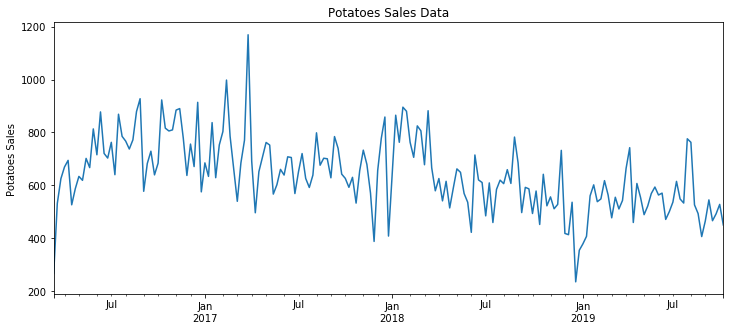

In [31]:
title='Potatoes Sales Data'
ylabel='Potatoes Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

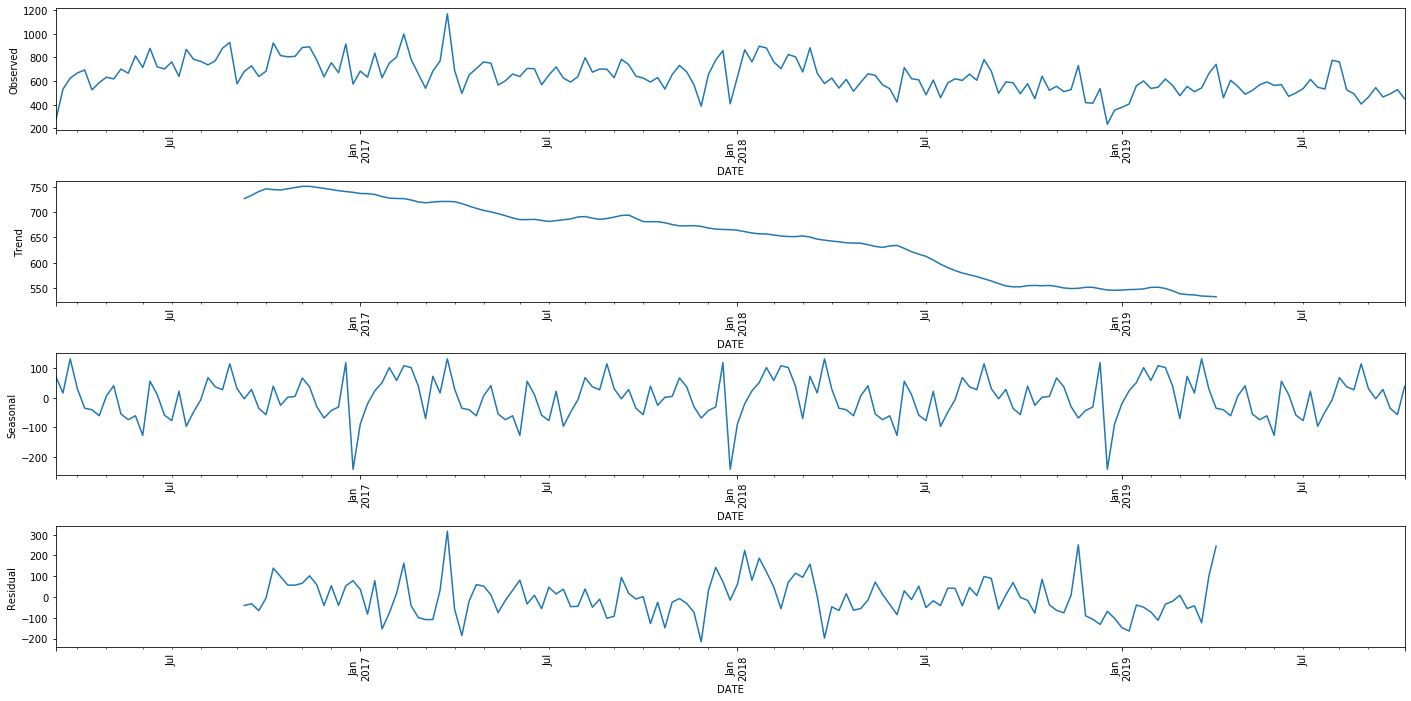

In [32]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('potatoes_decomp.png')

In [33]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [34]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [35]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -830.434
Date:                            Sun, 17 May 2020   AIC                           1668.867
Time:                                    11:44:19   BIC                           1680.459
Sample:                                03-14-2016   HQIC                          1673.578
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7830      0.065    -12.003      0.000      -0.911      -0.655
ar.S.L52      -0.8061      2.231     -0.361      0.718      -5.180       3.568
ma.S.L52       0.9972     82.408      0.012      0.990    -160.520     162.515
sigma2      1.279e+04   1.03e+06      0.012      0.990      -2e+06    2.02e+06
===================================================================================
Ljung-Box (Q):                       41.49   Jarque-Bera (JB):                 3.55
Prob(Q):                              0.41   Prob(JB):                         0.17
Heteroskedasticity (H):               0.99   Skew:                             0.20
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

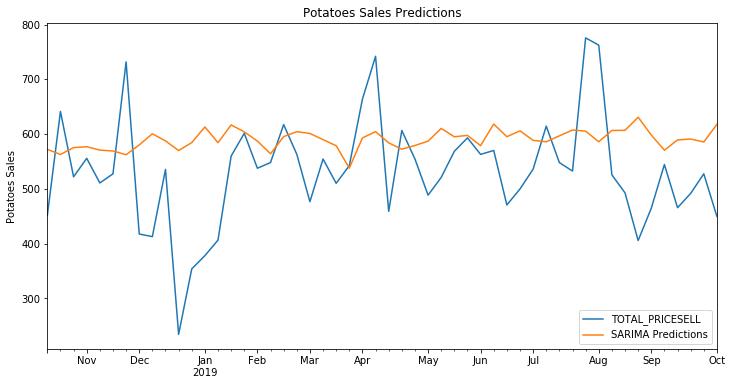

In [37]:
#Compare to validation data
title='Potatoes Sales Predictions'
ylabel='Potatoes Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [38]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 13688.01103
SARIMA RMSE: 116.9957736


In [39]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

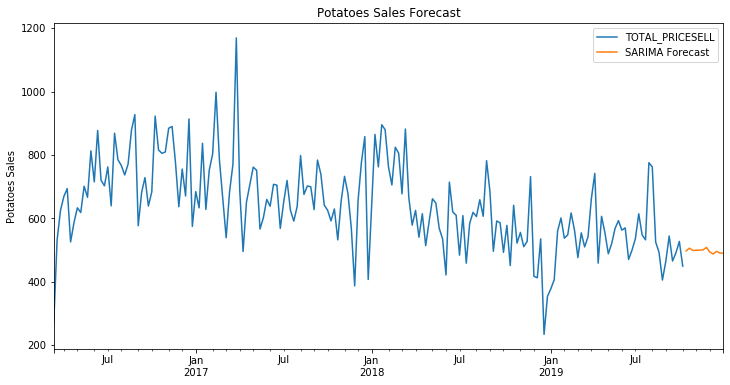

In [40]:
title='Potatoes Sales Forecast'
ylabel='Potatoes Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [41]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [42]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,265.86830,0
2016-03-21,531.15188,29
2016-03-28,624.64136,0
2016-04-04,669.08098,0
2016-04-11,693.95366,0


In [43]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -829.410
Date:                            Sun, 17 May 2020   AIC                           1668.820
Time:                                    11:44:36   BIC                           1683.309
Sample:                                03-14-2016   HQIC                          1674.708
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS    -1.7137      0.918     -1.866      0.062      -3.514       0.087
ma.L1           -0.7853      0.064    -12.313      0.000      -0.910      -0.660
ar.S.L52        -0.8192      2.512     -0.326      0.744      -5.743       4.105
ma.S.L52         0.9959     58.050      0.017      0.986    -112.781     114.772
sigma2        1.269e+04   7.05e+05      0.018      0.986   -1.37e+06    1.39e+06
===================================================================================
Ljung-Box (Q):                       41.38   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.41   Prob(JB):                         0.09
Heteroskedasticity (H):               1.05   Skew:                             0.33
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 13378.95532
SARIMAX RMSE: 115.6674342


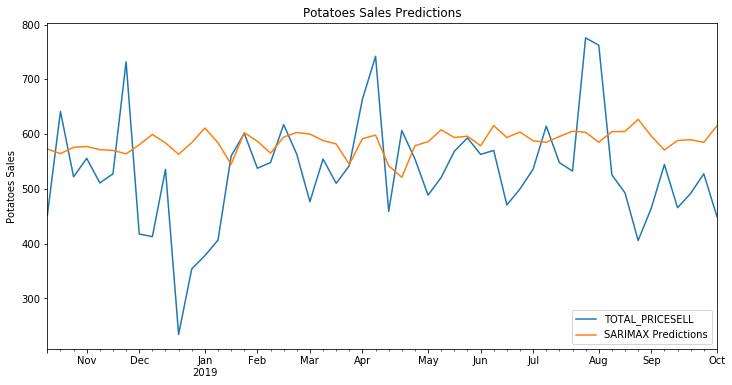

In [45]:
#Compare to validation data
title='Potatoes Sales Predictions'
ylabel='Potatoes Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [46]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [47]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

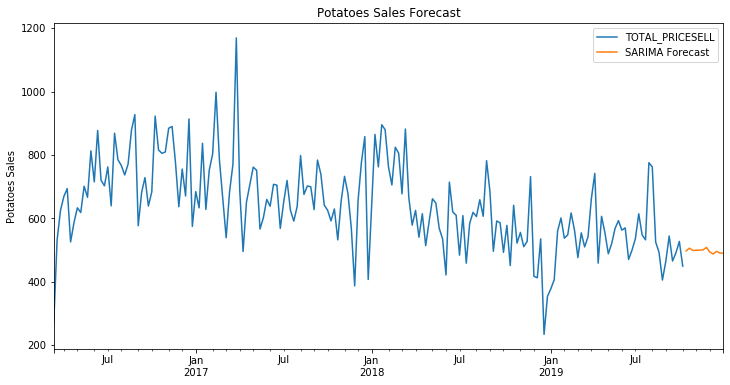

In [48]:
title='Potatoes Sales Forecast'
ylabel='Potatoes Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);